In [1]:
import numpy
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import pandas as pd
%matplotlib inline

### Brief Overview 

- The goal is to practice some essential probability and hypothesis testing sections.

It consists of two parts: 1- generative models and simulation; and 2- data analysis, interpretation and hypothesis testing. In both problems, you are given bits of information that guide you through solving the problem step-by-step before you are asked to repeat the analysis on a different question.

# PROBLEM 1
----

### Modeling Revenue from Memberships on a Training Website

* We are interested in modeling sales revenue for a membership-based training website over 2022. In summary, the website charges a monthly fee ($39.99) and enrollees can take as long as they need to complete their training. Students can quit the platform at any time without completing the training.

We know that:
  * Women finish training faster on average than men
  * Women quit less often on average than men 
  * Students have a small chance of dropping each month. As students get close to the end of the training, the probability of dropping decays (decreases), i.e., the longer a student has paid, the less likely they are to give up on their investment and leave the platform.
  
  * The site has seen a steady annual increase in memberships over the past five years. The average yearly increase was 13%, and the standard deviation was 1.4%. Memberships are expected to increase by the same percentage next year.
   * In 2021, 90,316 people enrolled on the training site
  
* We have access to some of the data from previous years. The data is stored in the file `memberships_info.csv` and can be downloaded from the following [URL](https://www.dropbox.com/s/evaaiu1mevw6t3j/memberships_info.csv?dl=1)

   
The data contains the following columns:

| Column    | Description                                    |
|-----------|------------------------------------------------|
| member_id | unique identifier of the member                |
| gender    | M for male and F for female                    |
| status    | C for completed and Q for quit                 |
| mem_duration  | Total duration of the membership in Months |
  


Your task is to develop a generative model, which can be used to estimate revenue for next year. Nevertheless, the model's parameters need to be identified and their underlying distributions hypothesized before their estimated values can be determined. 


### Reading the Data 

* Use `pandas` to read in the data into a variable called `sample_users`
* Based on the data in the tables, what is the proportion of males who completed the training?


In [2]:
sample_users = pd.read_csv("data/memberships_info.csv")

In [3]:
number_male_completed = sample_users[(sample_users["status"] == 'C') & (sample_users["gender"] == 'M')].shape[0]
number_male_total = sample_users[(sample_users["gender"] == 'M')].shape[0]
print('Number of male that completed the training: ', number_male_completed)
print('Total number of males enrolled : ', number_male_total)
print('Proportion: ', number_male_completed/number_male_total)

Number of male that completed the training:  45976
Total number of males enrolled :  76276
Proportion:  0.6027584036918558


### Generative Model for our Simulations

Below is a description of the generative model we will use. Our model will simulate yearly sales in 4 steps:

  1. Simulate a likely number of enrollees based on $\mu=13$ and $\sigma =1.4$ increase from last year (2021).
  
  2. You can simulate whether a particular enrollee will:
  
    2.1 Quit the training: In which case, generate a likely value representing the number of months of enrollment before quitting
      
    2.2 Complete the training: in which case, generate a likely value representing the number of months of enrollment before completing the training

  3. Compute the revenue from memberships based on the total number of months of enrollment simulated for each member.

* This strategy is shown in the figure below

<img src="https://www.dropbox.com/s/xvvof9g36m7pthq/generative_model_diagram.png?dl=1" alt="drawing" style="width:700px;"/>

### Estimating the 95% Confidence Interval of the Simulation

* We are not interested in one value, but rather the interval in which the revenue falls 95% of the time. Therefore, we need to repeat the experiment above a large number of times (say 5,000) to derive the 95% confidence interval.


###  1. Generating the Number of Enrollees

 * As mentioned earlier, the company that provides the training expects the increase in enrollments in 2022 to be comparable to annual increases in the past. The increase has, therefore, a mean $\mu=13$% and a standard deviation of $\sigma =1.4$% 
 * Given that last year's number of enrollees was 90,316, use the Gaussian (normal) distribution to sample a likely number of enrollees for 2022. This number will represent the number of enrollees in a single iteration of the generative model

* Save the value in a variable called `nb_enrollees`
  * Recall that you will need to convert the resulting value to an `int` since the gaussian sample generated is a continuous values  



In [4]:
## "The Empirical Rule states that 99.7% of data observed following a normal distribution lies within 3 standard deviations of the mean." (Investopedia, 2022)

mean = 13/100
std = 1.4/100
past_nb_enrollees = 90316

mean = past_nb_enrollees + (mean * past_nb_enrollees)
std = std * past_nb_enrollees

low = mean - (3 * std)
high = mean+ (3 * std)

nb_enrollees = numpy.random.randint(low, high)
nb_enrollees

104257

### Compute the Proportion of People who Quit Training in the Population of Enrollees

* Use the data in `sample_users` to build a 98% confidence interval of the proportion of enrollees who quit the training before completing. You can generate a single instance of the rate of people who quit by dividing by the number of  people who quit (`status == "Q"` in the data) by the number of people who complete the program (`status == "C"` in the data)

* Will build a 98% confidence interval by computing the proportion in 10,000 bootstrap iteration of the data

* Assing the the the confidence interval tuple to a variable called `quit_prop_conf_int`



In [5]:
bootstrap_means = []
data = sample_users["status"]

for i in range(10000):
    returns_data_100_bootstrap = np.random.choice(data, 100)
    quits = conclusions = 0

    for x in range(100):
        if returns_data_100_bootstrap[x] == 'C':
            conclusions += 1
        else: quits += 1
    bootstrap_means.append(quits/conclusions)

quit_prop_conf_int = np.percentile(bootstrap_means, (1, 99))
quit_prop_conf_int


array([0.33333333, 0.88679245])


### 2. Generating a Radom Quitting Probability

Approximately 98% of the time, the quitting parameter is within the 98% confidence interval. In order to incorporate this uncertainty in our model, we will randomly pick a quitting probability from this confidence interval and use it to estimate the number of people who quit each in iteration our our simualtion
 
  * Use `np.random.uniform(min, max)` to randomly pick a value in the interval.
  * ex. if the bounds of your quit_prop_conf_int are (0.2, 0.3), a possible value is 
  
```python  
  np.random.uniform(0.2, 0.3)
  >>> 0.225
  # this is equivalent to 
  # np.random.uniform(quit_prop_conf_int[0], quit_prop_conf_int[1])
```

Save the value in a variable called `quit_prop`

In [6]:
quit_prop = np.random.uniform(quit_prop_conf_int[0], quit_prop_conf_int[1])
quit_prop

0.6906732453656491

### 3. Simulating the Number for People Who Quit and Those Who Complete the Training

* Use the variables `nb_enrollees` and `quit_param` to determine the number of people who will complete the training and the number of enrollees who will quit.

* Save the value in `nb_enrollees_finish` and `nb_enrollees_quit` 

  * Recall that the resulting values are integers not floats.
  * Verify that
```
nb_enrollees_finish + nb_enrollees_quit == nb_enrollees
```

In [7]:
complet_prop = 1 - quit_prop
nb_enrollees_finish = complet_prop * nb_enrollees
nb_enrollees_quit = quit_prop * nb_enrollees

int(nb_enrollees_finish + nb_enrollees_quit)  == nb_enrollees

True

### Determining the Number of Payments Enrollees Make Before Quitting

* Here we will be modeling the number of months that a person remains enrolled before eventually quitting

* Recall that the probability of dropping declines as the students get closer to completing the training
  * A person is more likely to quit in the first month than in any other month 
  * The probability of unenrolling during month $t$ is always higher than the probability of unenrolling during month $t+1$
  * The longer the student has paid, the less likely they are to drop out
  
 
* The illustrations A, B and C below are all valid representations of the probability distribution that satisfy the constraints set above.
  * For illustration purposes, the function is represented in the range [1, 10].

<img src="https://www.dropbox.com/s/ys12ubh0mvmyji5/decay.png?dl=1" alt="drawing" style="width:1400px;"/>

### Identifying the Most Likely Parameters

* This three figure above (A, B and C) all represent exponential probability distributions
  https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html
 
* While we haven't covered this distribution in class, all we need to know is that this distribution has two parameters:
  * `loc`: represents the value at which the function has its maximum
  * `scale`: represents the "inverse rate of decay"
    * the larger the scale, the slower the function is to reach a probability of 0.
  
* In the example above, all three figures were generated with a `loc` of 1 since enrollees are most likely to quit during the first month than in any other month
* Figures A, B and C have different scale parameters; decays (`scale`) of `0.2`, `1` and `200` respectively

* Examples of how to use the exponential probability distribution (`expon`) are given below



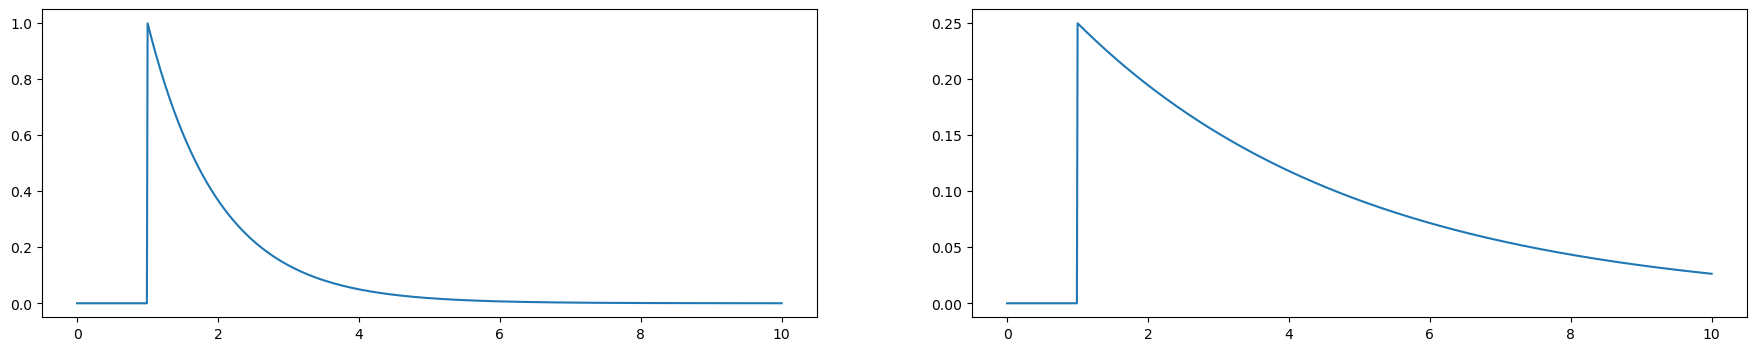

In [8]:
plt.figure(figsize=(22,4))
x = np.linspace(0, 10, 1000)

y_dist_1 = stats.expon(1, 1)
y_dist_2 = stats.expon(1, 4)


plt.subplot(1, 2, 1)
plt.plot(x, y_dist_1.pdf(x), label="$a=0.2$")


plt.subplot(1, 2, 2)
plt.plot(x, y_dist_2.pdf(x), label="$a=1$")


In [9]:
# Sampling 7 values from stats.expon with `loc=1` and `scale=2`
stats.expon(1, 2).rvs(7)

array([2.934472  , 2.45849708, 2.52747675, 1.01570737, 2.43252353,
       1.19176248, 1.05201594])

### Identifying the Scale Parameter that Maximizes the Likelihood (ML)

* We will set `loc=1` since enrollees are likely to quit during the first month. However, what value of `scale` maximizes the log-likelihood of our data?
  
  
* Before we answer this question, compute the log-likelihood of this dataset using a `scale` value of 5
 * Recall that the obsersed data here is the number of months a person remains enrolled before eventually quitting
   * Make sure that your data is the `mem_duration` for individuals with `status=="Q"`

* Also, to compute the log-likelihood of the data [2,1,2,3,4] and `location=1` and `scale=5`, we write:


```python
    log_pdfs = stats.expon(1, 4).logpdf([2,1,2,3,4])
    sum(log_pdfs)
    # or simply 
    # sum(stats.expon(1, 4).logpdf([2,1,2,3,4]))
```

* Note that above we chain operations by first building the distribution using `stats.expon(1, 4)` and, which we subsequently use to call the method `logpdf([2,1,2,3,4])`

In [10]:
data = sample_users[sample_users["status"] == "Q"]["mem_duration"]
log_pdfs = stats.expon(1, 5).logpdf(data)
sum(log_pdfs)

-127237.50193603487

### Estimating Scale Using the Maximum Likelihood

* Compute and plot the log-likelihood of `scale` values between 1 and 50 given the data

* Your graph should look like the one below.

  * The X-axis represents possible scale params
  * The Y-axis represents the log-likelihood of your data

<img src="https://www.dropbox.com/s/qo5t4qck68pbads/ML.png?dl=1" alt="drawing" style="width:1400px;"/>

* Notes:
  * I have marked the graph to indicate where likelihood is maximal
  * The x-axis ticks are intentionally missing. Make sure yours are not.


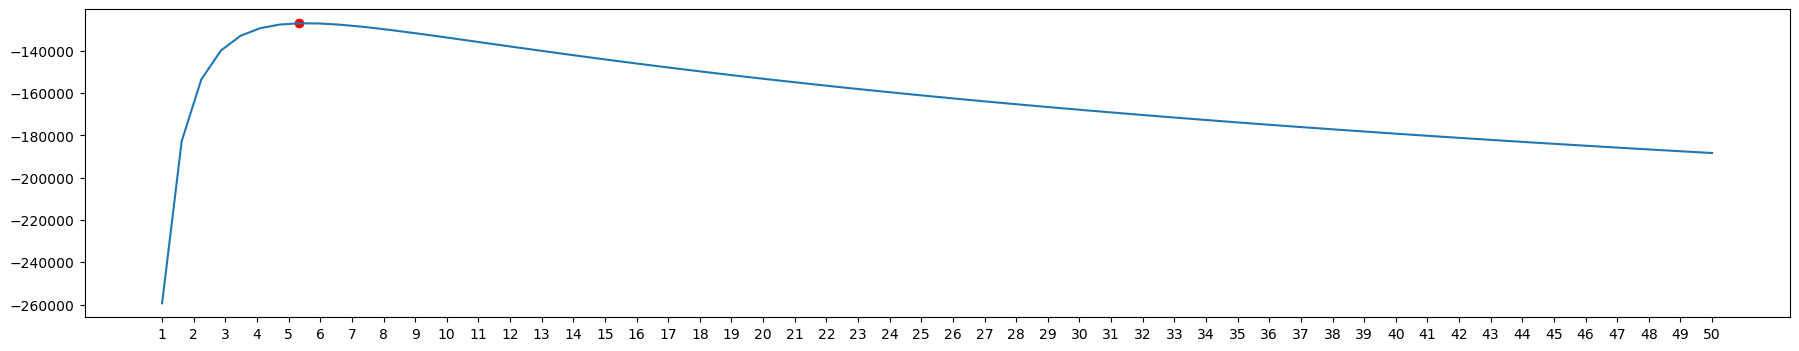

In [11]:
plt.figure(figsize=(22,4))
x = np.linspace(1, 50, 80)
y = [sum(stats.expon(1, i).logpdf(data)) for i in x]

plt.plot(x, y)
_ = plt.xticks(np.arange(1, 51, 1.0))
plt.scatter(x[np.argmax(y)], max(y), color='red')

### 4. Simulating Users Unenrolling from the Training

* Simulate the number of months users who quit are likely to have stayed on the platform before quitting.

* This can be done by sampling from the exponential using the `loc=1` and the `scale` parameter identified above. E.g.,. if your scale is 4, you can use: 

```python 
    scale =4
    nb_users = 1
    stats.expon(1, scale).rvs(nb_users)
    array([ 2.68001742])
    
```

* The above value tells us the user we simulated stayed on for 2.6 months before quitting. 
  *  To simulate multiple users, simply change the value of nb_users

Since users pay monthly, you can round the values up to the nearest integer
  *I.e., use `np.ceil` to determine the ceiling

* Simulate the number of months enrolled for all users in `nb_enrollees_quit`  
 * Save the value to a variable called `months_paid_before_quitting`.   

In [12]:
scale = 5
nb_users = int(nb_enrollees_quit)
months_paid_before_quitting = np.ceil(stats.expon(1, scale).rvs(nb_users))

### Modeling the Membership Duration for Enrollees who Complete the Training

* We will use a similar approach to derive the duration of enrollment for users who completed the training

  * Here we are not concerned by the gender difference.
    
* Plot a KDE of the duration of enrollment for enrollees who finished the training. 
  * Your graph should look like the following. 

<img src="https://www.dropbox.com/s/it164wz91kr44cz/kde.png?dl=1" alt="drawing" style="width:600px;"/>

Text(0, 0.5, 'Proportion')

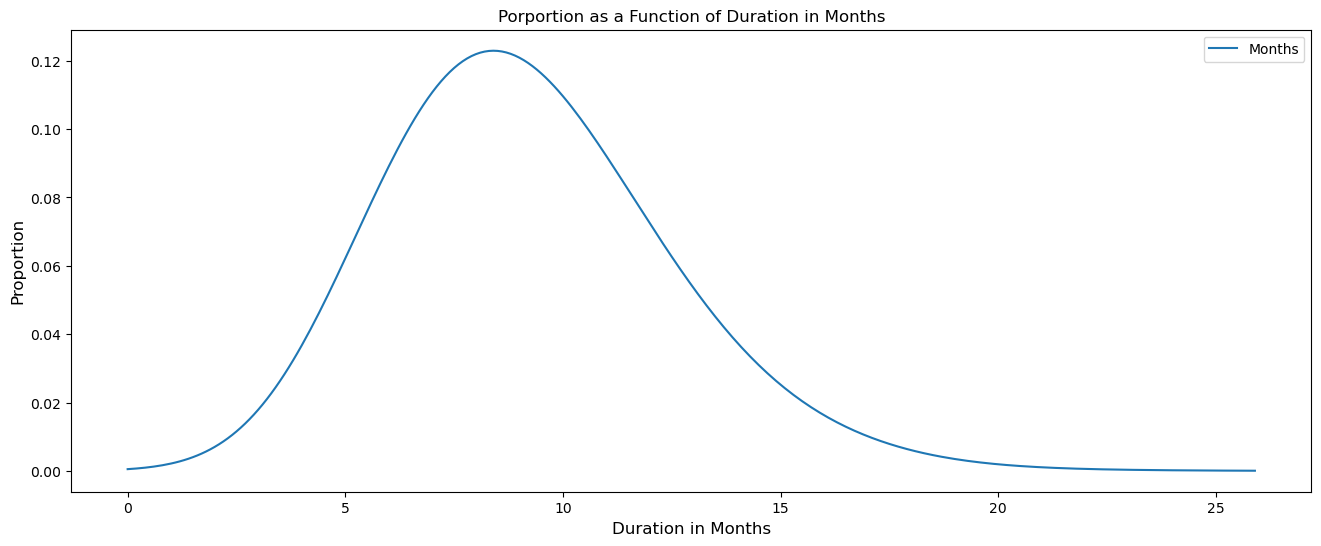

In [13]:
months_paid_before_completing = sample_users[sample_users["status"] == 'C']
months_paid_before_completing = months_paid_before_completing['mem_duration']
x_axis_id = np.arange(0, 26, 0.1)
kde_id = sp.stats.gaussian_kde(months_paid_before_completing, bw_method=0.5)
x_densities_id = kde_id.evaluate(x_axis_id)

plt.figure(figsize=(16,6))
plt.plot(x_axis_id, x_densities_id, label="Months")

plt.legend()
plt.title("Porportion as a Function of Duration in Months")
plt.xlabel('Duration in Months', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

### Visually identifying mean training completion time

* Based on the KDE above, how long does it take, on average, to complte the training?



In [14]:
print("Visually, since the peek is very high between 8.5 and 9, the mean should also be between those values. \nHowever, because the months goes further until 25-26, that could mean that the mean is on the right side of the curve, thus, 9 months.")

Visually, since the peek is very high between 8.5 and 9, the mean should also be between those values. 
However, because the months goes further until 25-26, that could mean that the mean is on the right side of the curve, thus, 9 months.


### Modeling the Membership Duration for Enrollees who Complete the Training - Cont'd 


* Searching online for similar-looking probability distributions, you find that your KDE resembles a gamma distribution. 
  
   https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html

* The gamma distribution takes a single parameter $a$ called the shape parameter.
  * See the documentation for `stats.gamma` in the `scipy` package

* Below are a couple of examples of usage of `stats.gamma`. The first was generated with $a=2$ and the second with $a=8$
  
<img src="https://www.dropbox.com/s/zv9yer46x2qno1x/two_gammas.png?dl=1" alt="drawing" style="width:1000px;"/>


### Computing the Maximum Likelihood Value of the Parameter $a$

* Use the Maximum Likelihood to identify the value of the parameter $a$ that maximizes the log-likelihood 
    
  * Compute and plot the log-likelihood for the values between 1 and 25
  
    * The X-axis represents possible distribution params
    * The Y-axis represents the log-likelihood of your data
  * Recall that tour data consists of the `mem_duration` for users where `status == "C"`
  
* Notes:
  * I clearly marked the graph to indicate where likelihood is maximal
  * The x-axis ticks are intentionally missing. Make sure yours are not.
  * You can  use the `logpdf` directly on the `gamma(x)` object 
  
<img src="https://www.dropbox.com/s/dahd99mz258curq/ML_gamma.png?dl=1" alt="drawing" style="width:800px;"/>



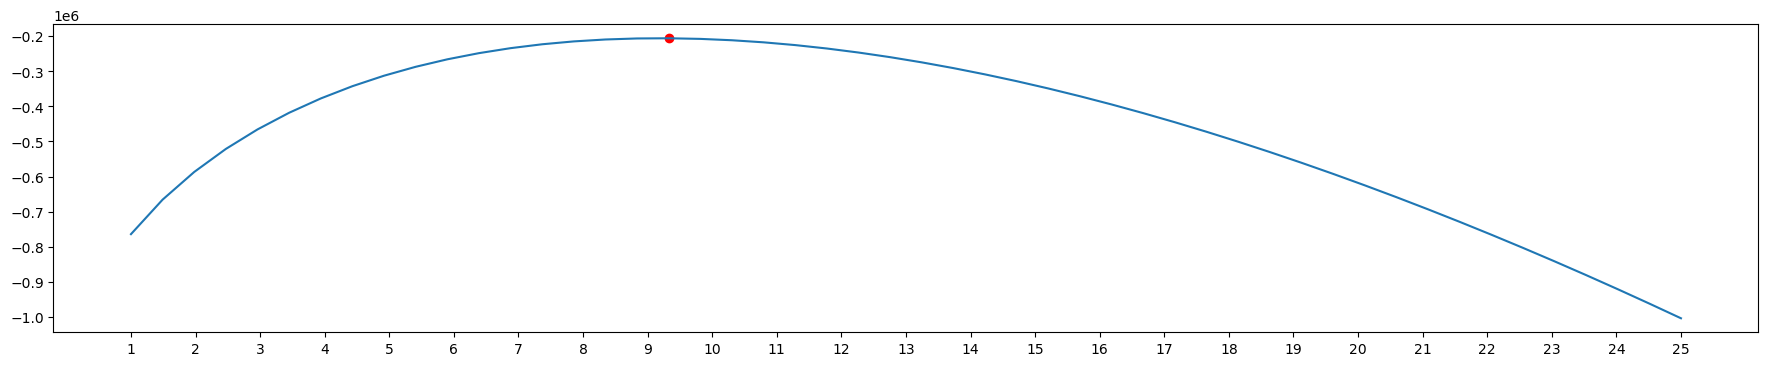

In [15]:
data = sample_users[sample_users["status"] == "C"]["mem_duration"]
x = np.linspace (1, 25, 50)
y = [sum(stats.gamma.logpdf(data, a=i, scale=1)) for i in x]

plt.figure(figsize=(22,4))
plt.plot(x, y)
_ = plt.xticks(np.arange(1, 26, 1.0))
plt.scatter(x[np.argmax(y)], max(y), color='red')

### Computing the Maximum Likelihood Value of the Parameter $a$ - Cont'd


* What is the value that maximizes the likelihood?
* Does this value align with what you observed after inspecting rhe KDE graph above?



In [16]:
print("The value that maximizes the likelihood is", int(x[np.argmax(y)]))

The value that maximizes the likelihood is 9


In [17]:
print("The value from the KDE is around 9, and value that maximizes the likelihood from the test above is also around 9. \nThus, the value align.")

The value from the KDE is around 9, and value that maximizes the likelihood from the test above is also around 9. 
Thus, the value align.


### 5. Simulating Users Completing the Training


* Using the gamma distribution and the parameter $a$ determined above, simulate the number of months it takes users to finish the training. To simulate the number of months a user may have remained unrolled before completing the training we simply sample from the gamma using the parameter $a$ identified above.

* E.g., for $a = 5$, you can use: 

```python 
    scale =4
    nb_users = 1
    stats.gamma(1, months_paid_before_completion).rvs(nb_users)
    array([ 5.112342])
    
```

* According to the value above, the simulated student stayed on for 5.1 months before quitting 
  * Change the value of `nb_users` to simulate multiple users

* Since users pay monthly, round up the values to the nearest integer
  * I.e., compute the ceiling using `np.ceil`

* Simulate the number of months enrolled for all users in `nb_enrollees_finish`  
 * Save the values to a variable called `months_paid_before_finishing`

In [18]:
nb_users = int(nb_enrollees_finish)
months_paid_before_finishing = np.ceil(stats.gamma(1, 9).rvs(nb_users))

### 6. Simulating Revenue for a Single Iteration

* Compute the total revenue for this iteration as the total number of months paid by users who completed the training and those who quit, times the monthly fee.
  * The total number of months of enrollement for users who completed the training is saved in `months_paid_before_finishing`
  * The total number of months of enrollement for users who did not complete the training is saved in `months_paid_before_quitting`
  * The monthly fee is 39.99



In [19]:
revenue = (sum(months_paid_before_finishing) + sum(months_paid_before_quitting)) * 39.99
revenue

32417973.48

### Build a 95% Confidence Interval for the Revenue

* Repeat the simulation above 5000 times to build a confidence interval. The steps you'll need to repeat are those described in text cells with the following headers:
    
  1. Generating the Number of Enrollees
  2. Generating a Radom Quitting Probability 
  3. Simulating the Number for People Who Quit and Those Who Complete the Training 
  4. Simulating Users Unenrolling from the Training
  5. Simulating Users Completing the Training
  6. Simulating Revenue for a Single Iteration


    
* The computation may take a few minutes to complete

In [ ]:
simulation_array = []
bootstrap_means = []
data = sample_users["status"]

# calculate number of enrollees (normal distrubution)
mean = 13/100
std = 1.4/100
past_nb_enrollees = 90316
mean = past_nb_enrollees + (mean * past_nb_enrollees)
std = std * past_nb_enrollees
low = mean - (3 * std)
high = mean+ (3 * std)

for x in range(5000):

    # get number of enrollees
    nb_enrollees = numpy.random.randint(low, high)

    # sample a random quit prop
    for i in range(1000):
        returns_data_100_bootstrap = np.random.choice(data, 100)
        quits = conclusions = 0

        for x in range(100):
            if returns_data_100_bootstrap[x] == 'C':
                conclusions += 1
            else:
                quits += 1
        bootstrap_means.append(quits/conclusions)

    quit_prop_conf_int = np.percentile(bootstrap_means, (1, 99))
    quit_prop = np.random.uniform(quit_prop_conf_int[0], quit_prop_conf_int[1])

    # get number of enrollees who quit
    # get number of enrollees who finish
    complet_prop = 1 - quit_prop
    nb_enrollees_finish = (1 - quit_prop) * nb_enrollees
    nb_enrollees_quit = quit_prop * nb_enrollees

    # compute # months payed before quitting
    scale = 5
    nb_users = int(nb_enrollees_quit)
    months_paid_before_quitting = np.ceil(stats.expon(1, scale).rvs(nb_users))

    # compute # months payed before finishing
    nb_users = int(nb_enrollees_finish)
    months_paid_before_finishing = np.ceil(stats.gamma(1, 5).rvs(nb_users))

    # compute the revenue and add value to some array.
    revenue = (sum(months_paid_before_finishing) + sum(months_paid_before_quitting)) * 39.99
    simulation_array.append(revenue)

simulation_array[:5]

### Taking into account gender differences 

* Repeat the analysis above while taking into consideration the differences between males and females. To do so, you'll need two additional parameters:

  * the proportion of males/females in the population of enrollees who quit the training, call it `male_female_prop_quit`
     * This is the parameter that you'll use to decide whether the person who unenrolls is a Male or Female

  * The proportion of males to females in the population of enrollees who complete the training, call it `male_female_prop_finish`
    * This is the parameter that you'll use to decide whether the person who unenrolls is a man or a woman.

* Rather than having a single parameter `scale` for the inverse decay of the exponential distribution, you will now have two parameters, one for males and a second for females
* Rather than having a single shape parameter $a$ for gamma distribution, you will now have two parameters, one for males and a second for females



In [ ]:
# FEMALE
female = sample_users[(sample_users["gender"] == 'F')]
female_quit_duration = female[female["status"] == "Q"]["mem_duration"]
female_finish_duration = female[female["status"] == "C"]["mem_duration"]

# Identifying the Scale Parameter that Maximizes the Likelihood (ML)
log_pdfs = stats.expon(1, 6).logpdf(female_quit_duration)
print("Scale Parameter that Maximizes the Likelihood (ML): ", sum(log_pdfs))

# Computing the Maximum Likelihood Value of the Parameter
plt.figure(figsize=(22,4))
x = np.linspace (1, 25, 50)
y = [sum(stats.gamma.logpdf(female_finish_duration, a=i, scale=1)) for i in x]

plt.plot(x, y)
_ = plt.xticks(np.arange(1, 26, 1.0))
plt.scatter(x[np.argmax(y)], max(y), color='red')


In [ ]:
# MALE
male = sample_users[(sample_users["gender"] == 'M')]
male_quit_duration = male[male["status"] == "Q"]["mem_duration"]
male_finish_duration = male[male["status"] == "C"]["mem_duration"]

# Identifying the Scale Parameter that Maximizes the Likelihood (ML)
log_pdfs = stats.expon(1, 6).logpdf(male_quit_duration)
print("Scale Parameter that Maximizes the Likelihood (ML): ", sum(log_pdfs))

# Computing the Maximum Likelihood Value of the Parameter
plt.figure(figsize=(22,4))
x = np.linspace (1, 25, 50)
y = [sum(stats.gamma.logpdf(male_finish_duration, a=i, scale=1)) for i in x]

plt.plot(x, y)
_ = plt.xticks(np.arange(1, 26, 1.0))
plt.scatter(x[np.argmax(y)], max(y), color='red')

In [ ]:
simulation_array_female = []
simulation_array_male = []
bootstrap_means = []
data = sample_users["status"]

# calculate number of enrollees (normal distrubution)
mean = 13/100
std = 1.4/100
past_nb_enrollees = 90316
mean = past_nb_enrollees + (mean * past_nb_enrollees)
std = std * past_nb_enrollees
low = mean - (3 * std)
high = mean+ (3 * std)

#male/female proportion
female_proportion = female.shape[0]/sample_users.shape[0]
male_proportion = male.shape[0]/sample_users.shape[0]

for x in range(5000):

    # get number of enrollees
    nb_enrollees = numpy.random.randint(low, high)

    # sample a random quit prop
    for i in range(1000):
        returns_data_100_bootstrap = np.random.choice(data, 100)
        quits = conclusions = 0

        for x in range(100):
            if returns_data_100_bootstrap[x] == 'C':
                conclusions += 1
            else:
                quits += 1
        bootstrap_means.append(quits/conclusions)

    quit_prop_conf_int = np.percentile(bootstrap_means, (1, 99))
    quit_prop = np.random.uniform(quit_prop_conf_int[0], quit_prop_conf_int[1])

    # get number of enrollees who quit
    # get number of enrollees who finish
    complet_prop = 1 - quit_prop
    nb_enrollees_finish = (1 - quit_prop) * nb_enrollees
    nb_enrollees_quit = quit_prop * nb_enrollees

    # male and female who quit and finish
    female_quit = int(nb_enrollees_quit * female_proportion)
    male_quit = int(nb_enrollees_quit * male_proportion)

    female_finish = int(nb_enrollees_finish * female_proportion)
    male_finish = int(nb_enrollees_finish * male_proportion)

    # compute months payed before quitting (scale for both are 6)
    # compute # months payed before finishing
    scale = 6
    a_male, a_female = 10, 9
        #female
    months_paid_before_quitting_female = np.ceil(stats.expon(1, scale).rvs(female_quit))
    months_paid_before_finishing_female = np.ceil(stats.gamma(1, a_female).rvs(female_finish))
        # male
    months_paid_before_quitting_male = np.ceil(stats.expon(1, scale).rvs(male_quit))
    months_paid_before_finishing_male = np.ceil(stats.gamma(1, a_male).rvs(male_finish))

    # compute the revenue and add value to some array.
    revenue_female = (sum(months_paid_before_finishing_female) + sum(months_paid_before_quitting_female)) * 39.99
    simulation_array_female.append(revenue_female)

    revenue_male = (sum(months_paid_before_finishing_male) + sum(months_paid_before_quitting_male)) * 39.99
    simulation_array_male.append(revenue_male)

print("Four Female Revenue: ", simulation_array_female[:4])
print("Four Male Revenue: ",simulation_array_male[:4])

### Conclusion


* Which do you think is the most accurate model, the one that takes into account the gender differences of the one that does not? Justify your answer.




In [20]:
print("I believe the model that takes into account the gender differences is the most accurate because there is a big disparity between the two gender and should be investigated separately. ")

I believe the model that takes into account the gender differences is the most accurate because there is a big disparity between the two gender and should be investigated separately. 


# PROBLEM 2
----

###  Average Medicare Payment and Hypothesis Testing 

* We have access to the average Medicare payment made by the Federal government to over 6,000 hospitals nationwide. Medicare payments are categorized according to `DRG Definitions`, which are diagnostic categories that describe the service provided. For instance, the average Medicare payment at  THE QUEENS MEDICAL CENTER for the diagnostic category "917 - POISONING & TOXIC EFFECTS OF DRUGS W MCC" was $15,305.21.

* We are interested in comparing the average payment across states to see if they are similar or not, regardless of diagnostic category. Naturally, by different, we are interested in seeing whether the difference is statistically significant.





### Loading  the data
* The data is stored in `hospital_charge_data.csv` available at the following [URL](https://www.dropbox.com/s/zqf56enddz6mhlf/hospital_charge_data.csv?dl=1)


* Load the data into a variable called `payment_data`
  * Select only the columns `['DRG Definition', "Provider Name", 'Provider State', 'Average Medicare Payments']`
  * Rename these columns as `['diagnostic', 'name', 'state', 'avg_medicare_payment']`



In [21]:
payment_data = pd.read_csv("data/hospital_charge_data.csv")
payment_data = payment_data[['DRG Definition', 'Provider Name', 'Provider State', 'Average Medicare Payments']]
payment_data = payment_data.rename({'DRG Definition':'diagnostic'}, axis=1)
payment_data = payment_data.rename({'Provider State':'state'}, axis=1)
payment_data = payment_data.rename({'Provider Name':'name'}, axis=1)
payment_data = payment_data.rename({'Average Medicare Payments':'avg_medicare_payment'}, axis=1)
payment_data.sort_values(by='avg_medicare_payment', ascending=False)

,diagnostic,name,state,avg_medicare_payment
39562,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,STANFORD HOSPITAL,CA,154620.81
150793,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,WESTCHESTER MEDICAL CENTER,NY,133177.26
109462,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,PINNACLE HOSPITAL,IN,130466.57
39529,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,WASHINGTON HOSPITAL,CA,113462.09
151394,870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,STANFORD HOSPITAL,CA,109303.21
...,...,...,...,...
161185,918 - POISONING & TOXIC EFFECTS OF DRUGS W/O MCC,DAVIS HOSPITAL AND MEDICAL CENTER,UT,1603.83
82238,313 - CHEST PAIN,THOMAS HOSPITAL,AL,1594.50
83089,313 - CHEST PAIN,CHRISTUS ST PATRICK HOSPITAL,LA,1400.57
83025,313 - CHEST PAIN,VIA CHRISTI HOSPITAL WICHITA ST TERESA INC,KS,1327.23


### Average Medicare Payment Value

* Compute the mean average medicare payment value for Idaho (ID) and Hawaii (HI). 

* Based on the observed means, do you believe that there is a statistically significant difference in medicare payments between the two states? Justify your answer.

In [22]:
payment_data.groupby("state").mean().loc[['ID', 'HI']]

/var/folders/94/dfws3bs526q9crvbr4m0tss80000gn/T/ipykernel_20351/2470776142.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  payment_data.groupby("state").mean().loc[['ID', 'HI']]


,avg_medicare_payment
state,
ID,8461.977514
HI,10967.475045


# FYI: Which are the Costliest Categories

* Post-surgery infections are the categories with the highest Medicare payments cost,
  * The most expensive category is `853 - INFECTIOUS & PARASITIC DISEASES W O.R. P....` 
    * there were 15 discharges in NY's  WESTCHESTER MEDICAL CENTER, with an average Medicare payment of $133,177. 
    
    * there were 86 discharges in LA's CEDARS-SINAI MEDICAL CENTER with an average medicare payment of $87,437
  
* The overall cost of surgical site infection alone in the US is estimated at $3.5 to $10 billion annually.

In [23]:
payment_data[payment_data["diagnostic"].str.contains("INFECTIOUS")].sort_values("avg_medicare_payment", ascending=False).head()

,diagnostic,name,state,avg_medicare_payment
150793,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,WESTCHESTER MEDICAL CENTER,NY,133177.26
150143,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,HOWARD UNIVERSITY HOSPITAL,DC,95701.42
150057,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,STANFORD HOSPITAL,CA,94614.03
150088,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,CEDARS-SINAI MEDICAL CENTER,CA,87437.85
150024,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,RONALD REAGAN UCLA MEDICAL CENTER,CA,86398.70


### Skewed Data

* The payments data in Idaho and Hawaii are highly skewed and most payments are below $15k$, with some up to $60k$ in both states. See graphs below.



Text(0.5, 1.0, 'avg_medicare_payment in Hawaii')

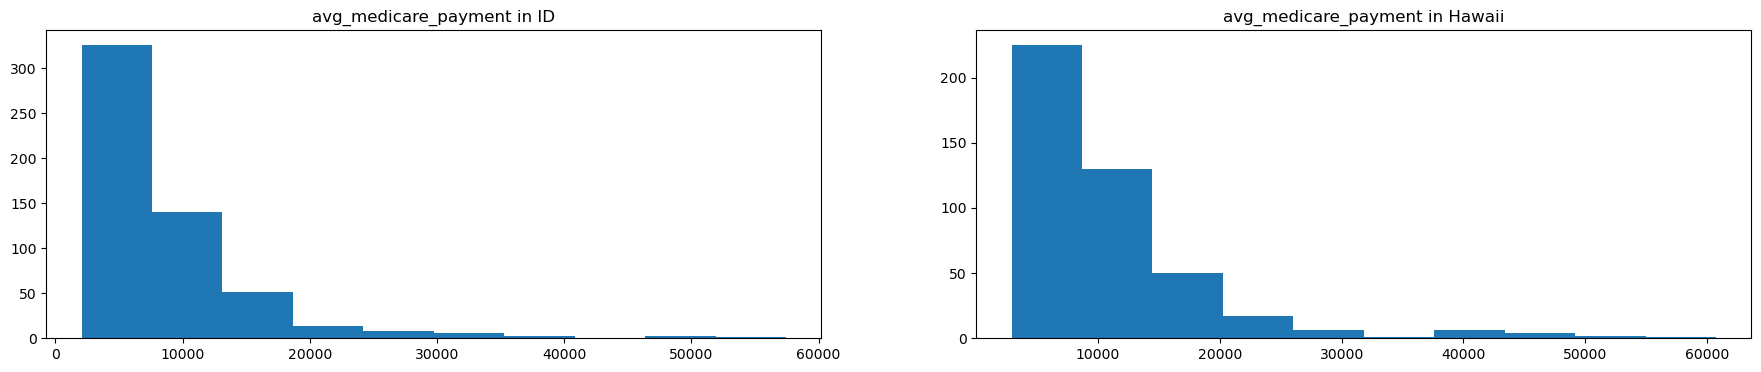

In [24]:
plt.figure(figsize=(22,4))
plt.subplot(1, 2, 1)
_ = plt.hist(payment_data[payment_data["state"] == "ID"]["avg_medicare_payment"])
plt.title("avg_medicare_payment in ID")
plt.subplot(1, 2, 2)
_ = plt.hist(payment_data[payment_data["state"] == "HI"]["avg_medicare_payment"])
plt.title("avg_medicare_payment in Hawaii")

### Log-Transforming the Data


* As discussed in class, data which follow bell-shaped distributions tend to be easier to work with in hypothesis testing.
    * Bootstrapping is not recommended with skewed data.

* Compute the `log` (base 10) of the `avg_medicare_payment` column and save the result to a new column called `log_avg_medicare_payment`

In [25]:
log_avg_medicare_payment = payment_data
log_avg_medicare_payment['avg_medicare_payment'] = np.log(payment_data['avg_medicare_payment'])
log_avg_medicare_payment.sort_values(by='avg_medicare_payment', ascending=False)

,diagnostic,name,state,avg_medicare_payment
39562,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,STANFORD HOSPITAL,CA,11.948731
150793,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,WESTCHESTER MEDICAL CENTER,NY,11.799436
109462,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,PINNACLE HOSPITAL,IN,11.778872
39529,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,WASHINGTON HOSPITAL,CA,11.639224
151394,870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,STANFORD HOSPITAL,CA,11.601881
...,...,...,...,...
161185,918 - POISONING & TOXIC EFFECTS OF DRUGS W/O MCC,DAVIS HOSPITAL AND MEDICAL CENTER,UT,7.380150
82238,313 - CHEST PAIN,THOMAS HOSPITAL,AL,7.374315
83089,313 - CHEST PAIN,CHRISTUS ST PATRICK HOSPITAL,LA,7.244635
83025,313 - CHEST PAIN,VIA CHRISTI HOSPITAL WICHITA ST TERESA INC,KS,7.190849


# Plotting the Hawaii KDE

* Plot the `log_avg_medicare_payment` KDE for Hawaii 
    
* Your curve should look like the one below

* Notice that: 
  * The KDE is smooth (as opposed to having jagged peaks)
   * The bandwidth was selected so that the range (x-axis) is mimized

* In the example below, x- and y-axis labels are missing. Your final graph should be labeled appropriately and should have a title

<img src="https://www.dropbox.com/s/i98rzkjiajz2by2/kde_hawaii.png?dl=1" alt="drawing" style="width:700px;"/>

Text(0, 0.5, 'Proportion')

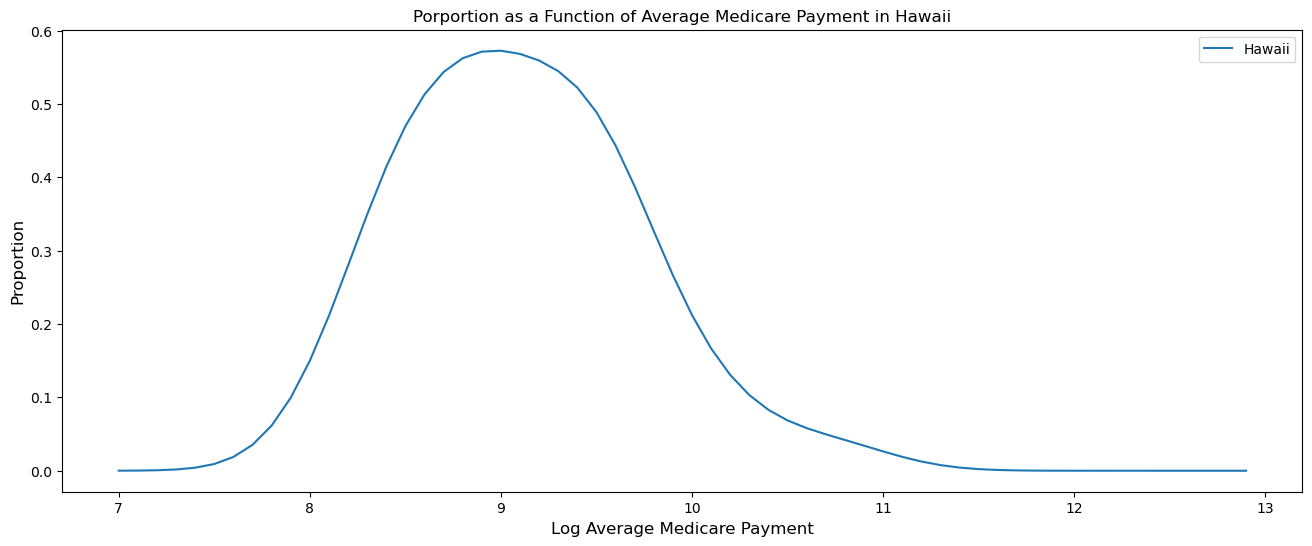

In [26]:
log_avg_medicare_payment_hi = log_avg_medicare_payment[log_avg_medicare_payment["state"] == 'HI']
log_avg_medicare_payment_hi = log_avg_medicare_payment_hi['avg_medicare_payment']

x_axis = np.arange(7, 13, 0.1)
kde = sp.stats.gaussian_kde(log_avg_medicare_payment_hi, bw_method=0.5)
x_densities = kde.evaluate(x_axis)

plt.figure(figsize=(16,6))
plt.plot(x_axis, x_densities, label="Hawaii")

plt.legend()
plt.title("Porportion as a Function of Average Medicare Payment in Hawaii")
plt.xlabel('Log Average Medicare Payment', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

### Interpreting the Hawaii Emprical Distribution

* According to the KDE plot above, what is the mean `avg_medicare_payment`? 
  * Plot the mean `avg_medicare_payment` and its density on your graph 


* Your graph should look like the one below     
  * Note that lines in the example below are intentionally drawn at a value that may be different from the true mean  
  * Make sure the vertical and horizontal lines in your graph match the mean and its density respectively
  

* Use the functions and `plt.vline` to plot the lines


<img src="https://www.dropbox.com/s/boiakmsgxw69z1r/interpreting_kde.png?dl=1" alt="drawing" style="width:800px;"/>

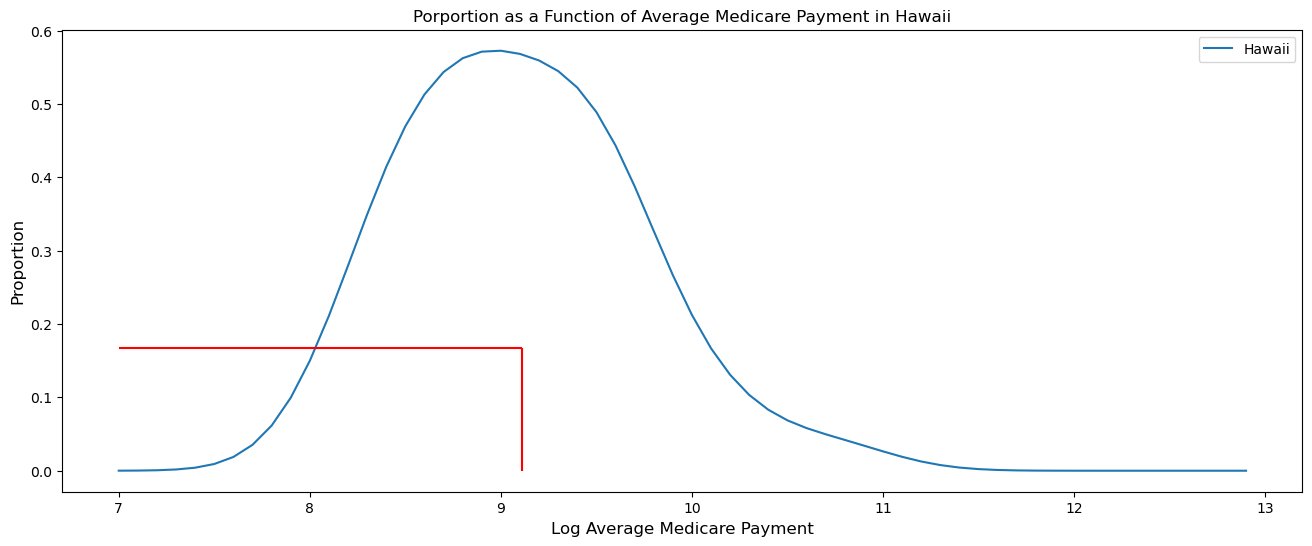

In [27]:
plt.figure(figsize=(16,6))
plt.plot(x_axis, x_densities, label="Hawaii")

plt.legend()
plt.title("Porportion as a Function of Average Medicare Payment in Hawaii")
plt.xlabel('Log Average Medicare Payment', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.vlines(log_avg_medicare_payment_hi.mean() , 0, x_densities.mean() , colors ="red")
plt.hlines(x_densities.mean(), 7, log_avg_medicare_payment_hi.mean() , colors ="red")

### Interpreting the Hawaii Emprical Distribution

* According to the `KDE` plot above, what is the probability of observing an average payment greater than $25,000

  * The *KDE* object works in a similar fashion to any of the probability distributions in `scipy`
  
    * Note that what you are asked to compute here is not the density but the probability avg-payments > $25k
    
    * Since the total probability under the curve sums to 1, then the `avg_medicare_payment`  > $25k should be less than 1.
    
   * Also, recall that your payment values are log-transformed

* Use `matplotlib`'s `fill_between` to paint the area under the curve representing that area. 

The probability of an average payment greater than 25,000 is:  0.058823529411764705


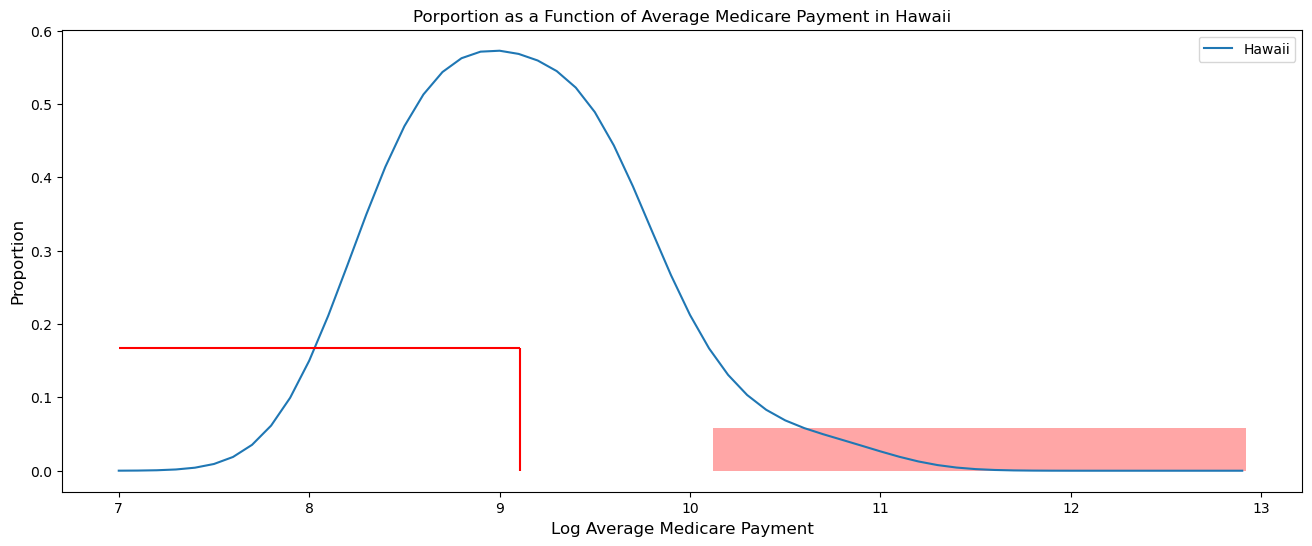

In [28]:
plt.figure(figsize=(16,6))
plt.plot(x_axis, x_densities, label="Hawaii")

plt.legend()
plt.title("Porportion as a Function of Average Medicare Payment in Hawaii")
plt.xlabel('Log Average Medicare Payment', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.vlines(log_avg_medicare_payment_hi.mean() , 0, x_densities.mean() , colors ="red")
plt.hlines(x_densities.mean(), 7, log_avg_medicare_payment_hi.mean() , colors ="red")

x = np.arange(10.12, 13, 0.1)
prob_25000 = sum(numpy.array(log_avg_medicare_payment_hi) > np.log(25000))/len(log_avg_medicare_payment_hi)
plt.fill_between(x, y1=prob_25000 , facecolor='red', alpha=0.35)
print("The probability of an average payment greater than 25,000 is: ", prob_25000)


 ### Plotting Both KDEs   

* Plot the Hawaii and Idaho `log_avg_medicare_payment` distributions on the same plot

* Your plot should look like the following

<img src="https://www.dropbox.com/s/tej47hhhxc18tdd/both_kdes.png?dl=1" alt="drawing" style="width:700px;"/>


* Label the x-axis and y-axis and choose a title for your plot.

According to your plot, do you believe that the average payment across both states is different? Explain your answer.




Text(0, 0.5, 'Proportion')

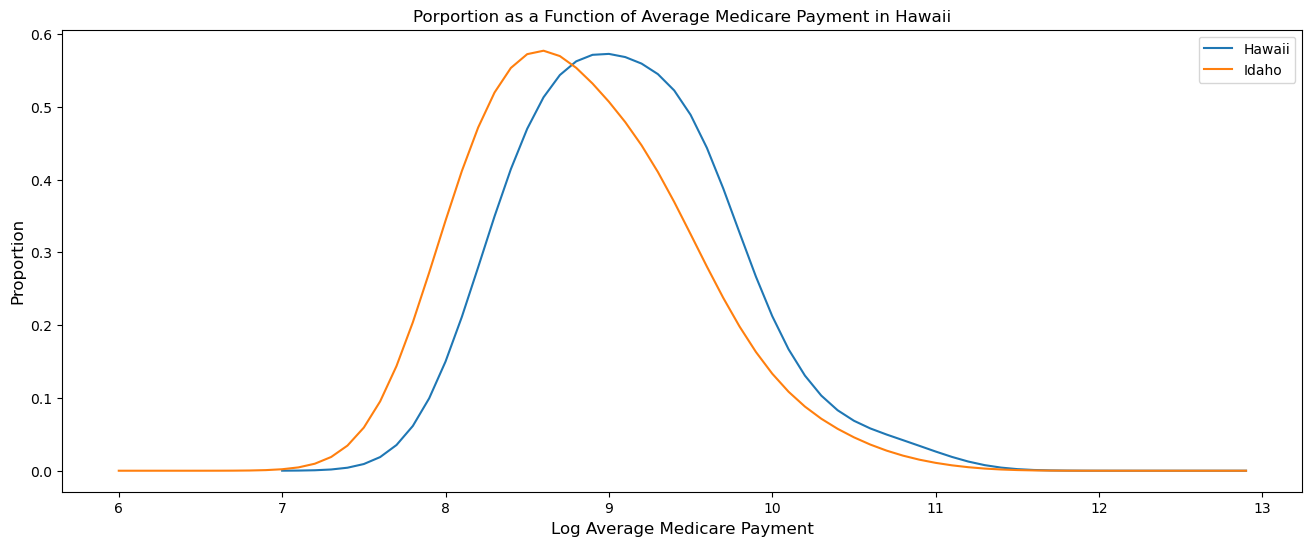

In [29]:
# extract data for Idaho
log_avg_medicare_payment_id = log_avg_medicare_payment[log_avg_medicare_payment["state"] == 'ID']
log_avg_medicare_payment_id = log_avg_medicare_payment_id['avg_medicare_payment']
x_axis_id = np.arange(6, 13, 0.1)
kde_id = sp.stats.gaussian_kde(log_avg_medicare_payment_id, bw_method=0.5)
x_densities_id = kde_id.evaluate(x_axis_id)

plt.figure(figsize=(16,6))
plt.plot(x_axis, x_densities, label="Hawaii")
plt.plot(x_axis_id, x_densities_id, label="Idaho")

plt.legend()
plt.title("Porportion as a Function of Average Medicare Payment in Hawaii")
plt.xlabel('Log Average Medicare Payment', fontsize=12)
plt.ylabel('Proportion', fontsize=12)


### Hypothesis Testing

* Is there a statistically significant difference between Hawaii and Idaho in terms of log_avg_medicare_payment? Here are the hypotheses we will test:

* Null Hypothesis ($H_0$)
  * The mean values across both state are the same and any differenc is due to solely sampling

* Alternative Hypothesis ($H_A$)
  * The mean values across both state are different
    * The observed difference is not due to chance
    



### Exracting the Data

* First, we will combine the average Medicaid payments from both states into a single `numpy` `array` called `log_avg_medicare_payment_hi_id`. This will allow us to work with the data more easily.

  * Your `numpy` array should contain 993 entries


In [30]:
log_avg_medicare_payment_hi_id = log_avg_medicare_payment[(log_avg_medicare_payment["state"] == 'ID') | (log_avg_medicare_payment["state"] == 'HI') ]
log_avg_medicare_payment_hi_id = np.array(log_avg_medicare_payment_hi_id['avg_medicare_payment'])
log_avg_medicare_payment_hi_id.shape

(993,)

### Computing the Observed Test Statistic

* Since we are interested in the difference between both averages, i.e., avg_medicare_payment in Hawaii and Idaho, a good test statistic is, therefore, the difference between the sample means in both states. 
* Compute the observed test statistic and save it to a variable called `observed_test_stat`

In [31]:
observed_test_stat = log_avg_medicare_payment_hi.mean() - log_avg_medicare_payment_id.mean()
observed_test_stat

0.2764453833037894

### Generating Data Under the Null Hypothesis: Single Iteration

* Under the null hypothesis, we assume that Hawaii and Idaho data come from the same distribution, and therefore, have the same parameters

* We can use permutations to simulate another set of samples from Hawaii and Idaho.

To generate data for a single iteration we will:

  1. Shuffle the values in `log_avg_medicare_payment_hi_id`
  2. Select two new samples to represent Hawaii and Idaho. The samples must have the same sizes as in the original data.
  3. Compute the difference between the mean `log_avg_medicare_payment` across both states.
  4. Store the value in a variable called `perm_diff`


In [32]:
np.random.shuffle(log_avg_medicare_payment_hi_id)
hawaii_sample = log_avg_medicare_payment_hi_id[:442]
idaho_sample = log_avg_medicare_payment_hi_id[442:]
perm_diff = np.mean(hawaii_sample) - np.mean(idaho_sample)
perm_diff

-0.05701314800326962

* Repeat the process described above 5,000 times. In each iteration save the difference in means between the two bootstrapped datasets to an array called `perm_diffs`
* Plot the resulting distribution of the means 
  * You may use any plot type you deem appropriate for this use case
* Use `plt.scatter` to plot in red the observed test statistic

* The result should look "somewhat" like the graph below
<img src="https://www.dropbox.com/s/doln0egikkbar52/diff_hi_id.png?dl=1" alt="drawing" style="width:700px;"/>


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Proportion')

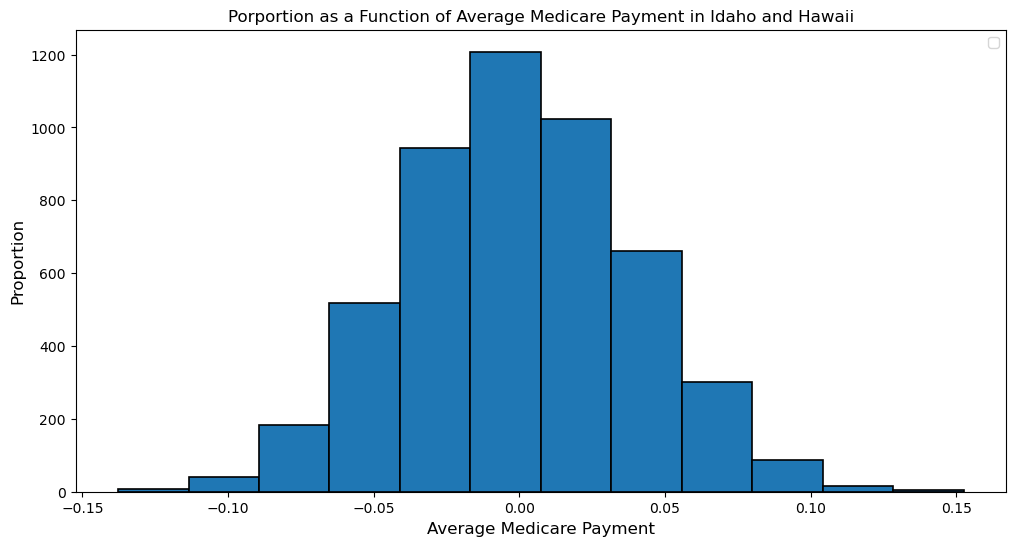

In [33]:
plt.figure(figsize=(12,6))
perm_diffs = []


for _ in range(5000):
    np.random.shuffle(log_avg_medicare_payment_hi_id)
    hawaii_sample = log_avg_medicare_payment_hi_id[:442]
    idaho_sample = log_avg_medicare_payment_hi_id[442:]
    perm_diffs.append(np.mean(hawaii_sample) - np.mean(idaho_sample))

_ = plt.hist(perm_diffs, edgecolor='k', linewidth=1.2, bins=12)

plt.legend()
plt.title("Porportion as a Function of Average Medicare Payment in Idaho and Hawaii")
plt.xlabel('Average Medicare Payment', fontsize=12)
plt.ylabel('Proportion', fontsize=12)


### Computing the p-value for the test

* Compute the p-value associated with your test statistic and state whether you have ground to reject the null hypothesis.
  * Be sure to provide your `p-value` to justify your answer.

In [34]:
mean_diff_hi_id = np.mean(np.array(log_avg_medicare_payment_hi)) - np.mean(np.array(log_avg_medicare_payment_id))
p_val = sum(perm_diffs >= mean_diff_hi_id)/len(perm_diffs)

print("P-value: ", p_val)
print("As we know, a p-value less than 0.05 (typically ≤ 0.05) is statistically significant. \nSince the p-value is 0, then there is a statistical significance between the two datasets")
print("The test hypothesis should be rejected.")

P-value:  0.0
As we know, a p-value less than 0.05 (typically ≤ 0.05) is statistically significant. 
Since the p-value is 0, then there is a statistical significance between the two datasets
The test hypothesis should be rejected.


### Hypothesis testing with values from DC

* Repeat the hypothesis test above by testing Hawaii and DC. Use the first cells below, to run your code and plot the empirical bootstrap distribution and the second to answer whether the data are statistically significantly similar or now. Include the `p-value` to support your conclusion

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Proportion')

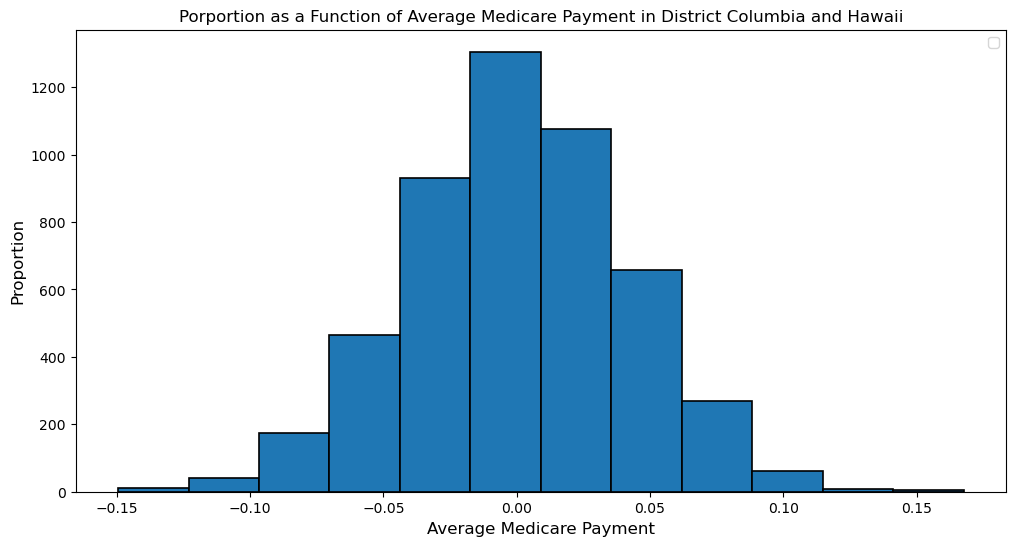

In [35]:
# get the data for HI and DC
log_avg_medicare_payment_hi_dc = log_avg_medicare_payment[(log_avg_medicare_payment["state"] == 'DC') | (log_avg_medicare_payment["state"] == 'HI') ]
log_avg_medicare_payment_hi_dc = np.array(log_avg_medicare_payment_hi_dc['avg_medicare_payment'])

# shuffle original data, get a new sample for each state, and the difference between the mean for both states.
plt.figure(figsize=(12,6))
perm_diffs2 = []

for _ in range(5000):
    np.random.shuffle(log_avg_medicare_payment_hi_dc)
    hawaii_sample2 = log_avg_medicare_payment_hi_dc[:442]
    district_sample = log_avg_medicare_payment_hi_dc[442:]
    perm_diffs2.append(np.mean(hawaii_sample2) - np.mean(district_sample))

_ = plt.hist(perm_diffs2, edgecolor='k', linewidth=1.2, bins=12)

plt.legend()
plt.title("Porportion as a Function of Average Medicare Payment in District Columbia and Hawaii")
plt.xlabel('Average Medicare Payment', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

In [36]:
log_avg_medicare_payment_dc = log_avg_medicare_payment[(log_avg_medicare_payment["state"] == 'DC')]
log_avg_medicare_payment_dc = log_avg_medicare_payment_dc['avg_medicare_payment']

mean_diff_hi_id = np.mean(np.array(log_avg_medicare_payment_hi)) - np.mean(np.array(log_avg_medicare_payment_dc))
p_val = sum(perm_diffs2 >= mean_diff_hi_id) / len(perm_diffs2)
print("P-value: ", p_val)
print("Since the p-value is 0.7, then there isn't a statistical significance between the two datasets")

P-value:  0.775
Since the p-value is 0.7, then there isn't a statistical significance between the two datasets
